Configuration & Path Setup

In [34]:
%load_ext autoreload
%autoreload 2

import warnings

# Ignore FutureWarnings from Scikit-Learn to clean up plot outputs
warnings.filterwarnings("ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Identify the correct path on own computer

**goal** : not to have to change any path manually when running the code

In [15]:
import os
import sys

# 1. Detect project root (go up until 'src' folder is found)
current_dir = os.getcwd()
project_root = current_dir

while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find project root")
    project_root = parent

# 2. Add project root to Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# 3. Data folder path
DATA_PATH = os.path.join(project_root, "data")

print("Project root:", project_root)
print("DATA_PATH:", DATA_PATH)


Project root: /home/delaunan/code/delaunan/clintrialpredict
DATA_PATH: /home/delaunan/code/delaunan/clintrialpredict/data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Modules/Closses
from src.data.data_loader import ClinicalTrialLoader
from src.data.preprocessing import get_preprocessor

### Loading of source data project_data.csv
Delete the one already present in clintrialpredict/data/ if you want the latest version. <br>
if data_project.csv already exists in clintrialpredict/data/, the existing one will not be replaced by the latest one <br>
**goal** : not to have to rerun and build the source file every time.

In [17]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (57108, 148)


### Audit of features in data_project.csv (to be runned only to dig deeper)
Audit file with all information saved to clintrialpredict/data/audit_features.txt

In [22]:
from src.data.audit_utils import run_master_audit

#Run the audit of features loaded into project_data.csv (will generate audit_full_report.txt in your data folder)

run_master_audit(DATA_PATH)

Reading /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv...
[1/9] Checking Dataset Health...
[2/9] Analyzing Categorical Risk Signals...
[3/9] Analyzing Numerical Impact...
[4/9] Generating Preprocessing Strategy...
[5/9] Calculating Correlations...
[6/9] Ranking Categorical Features...
[7/9] Checking Collinearity...
[8/9] Running Business Logic Checks...
[9/9] Writing Documentation...

Done. Audit saved to /home/delaunan/code/delaunan/clintrialpredict/data/audit_features.txt


### Train Test Split (default 80/20)

In [23]:
from src.models.train_test_split import temporal_train_test_split

# --- TRAIN TEST SPLIT ---
SPLIT_PERCENTAGE = 0.80

print(f"\nTesting Split with {SPLIT_PERCENTAGE*100}% Training Data...")


X_train, X_test, y_train, y_test = temporal_train_test_split(df, train_ratio=SPLIT_PERCENTAGE)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Testing Split with 80.0% Training Data...

 TEMPORAL SPLIT AUDIT (Train Ratio: 80%)
METRIC               | TRAIN SET            | TEST SET             | TOTAL               
-------------------------------------------------------------------------------------
Date Range           | 2005-2016            | 2016-2018            | 2005-2018
Total Trials         | 45686                | 11422                | 57108
Success (0)          | 38534                | 9574                 | 48108
Failures (1)         | 7152                 | 1848                 | 9000
Failure Rate         | 15.65%               | 16.18%               | 15.76%

X_train shape: (45686, 147)
y_train shape: (45686,)


### Model Training (model.fit)

In [ ]:
from sklearn.linear_model import LogisticRegression
from src.data.preprocessing import get_preprocessor
from sklearn.pipeline import Pipeline

# --- 1. Define the Model ---
print("Initializing Logistic Regression...")
model = Pipeline([
    ('preprocessor', get_preprocessor()),
    ('classifier', LogisticRegression(
        # --- Critical ---
        class_weight='balanced',
        max_iter=1000,
        random_state=42,

        # --- Defaults Spelled Out ---
        penalty='l2',       # Ridge Regularization
        C=1.0,              # Standard Strength
        solver='lbfgs',     # Standard Optimizer
        fit_intercept=True  # Learn Bias
    ))
])


# --- 2. Train ---
# We use X_train and y_train directly from Block 1
print("Fitting Model...")
model.fit(X_train, y_train)

print("✅ Baseline Model Trained!")

Initializing Logistic Regression...
Fitting Model...
✅ Baseline Model Trained!


### Overfitting / underfitting behavior


>>> Running Temporal Learning Curve...

 DIAGNOSTIC: TEMPORAL LEARNING CURVE
Computing learning curve... (This may take a moment)

[RESULTS]
Final Training Score:   0.7976
Final Validation Score: 0.6271
Generalization Gap:     0.1705
>> DIAGNOSIS: High Overfitting. The model is memorizing historical noise.


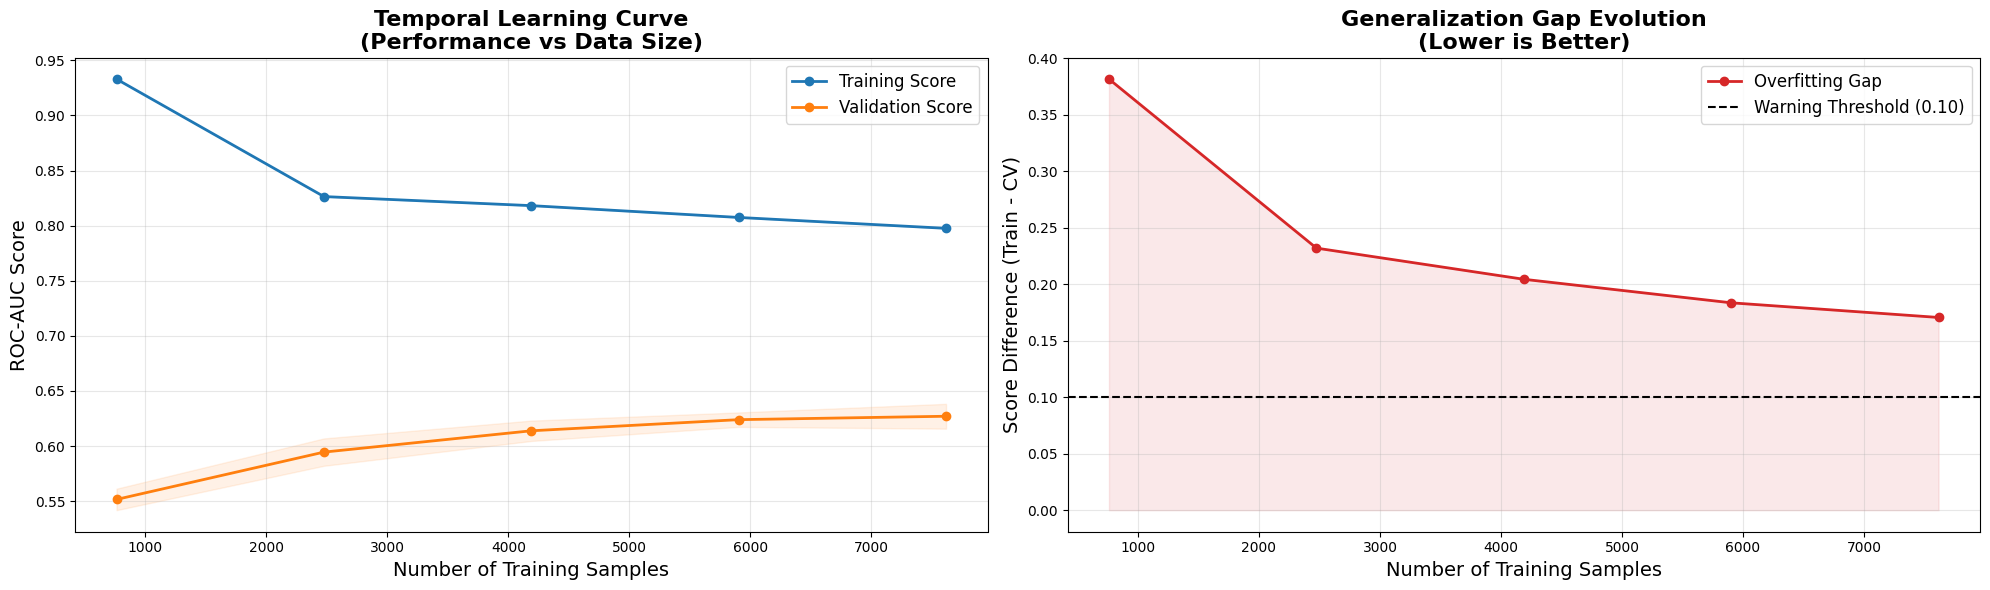

In [50]:
from src.models.evaluate import plot_learning_curve

# --- 1. RUN TEMPORAL LEARNING CURVE ---
# This generates the Learning Curve to check for Overfitting/Underfitting
# cv=5 means it will test on 5 different time periods (expanding window)
print("\n>>> Running Temporal Learning Curve...")
plot_learning_curve(model, X_train, y_train, cv=5)

### Evaluation

>>> Running Standard Evaluation...

 PERFORMANCE AUDIT: Logistic Regression (Baseline)

[1] DISCRIMINATORY POWER (ROC-AUC): 0.6785
    - Industry Benchmark: 0.70 (Public Data) | 0.78+ (Proprietary Data)
    - Status: ❌ Weak

[2] FAILURE DETECTION CAPABILITY (PR-AUC): 0.2712
    - Baseline (Random Guess): 0.1618
    - Lift: 1.7x better than random guessing.

[3] PROBABILITY RELIABILITY (Brier Score): 0.2167
    - Goal: < 0.15 for high-confidence financial modeling.
--------------------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT (With Interpretation):
                precision    recall  f1-score   support

 Completed (0)       0.89      0.68      0.77      9574   <-- Correctly approves 68% of safe trials
Terminated (1)       0.26      0.59      0.36      1848   <-- Catches 59% of failures (Precision: 26%)

      accuracy                           0.66     11422
     macro avg       0.58      0.63      0.56     11422
  weighted avg       0.

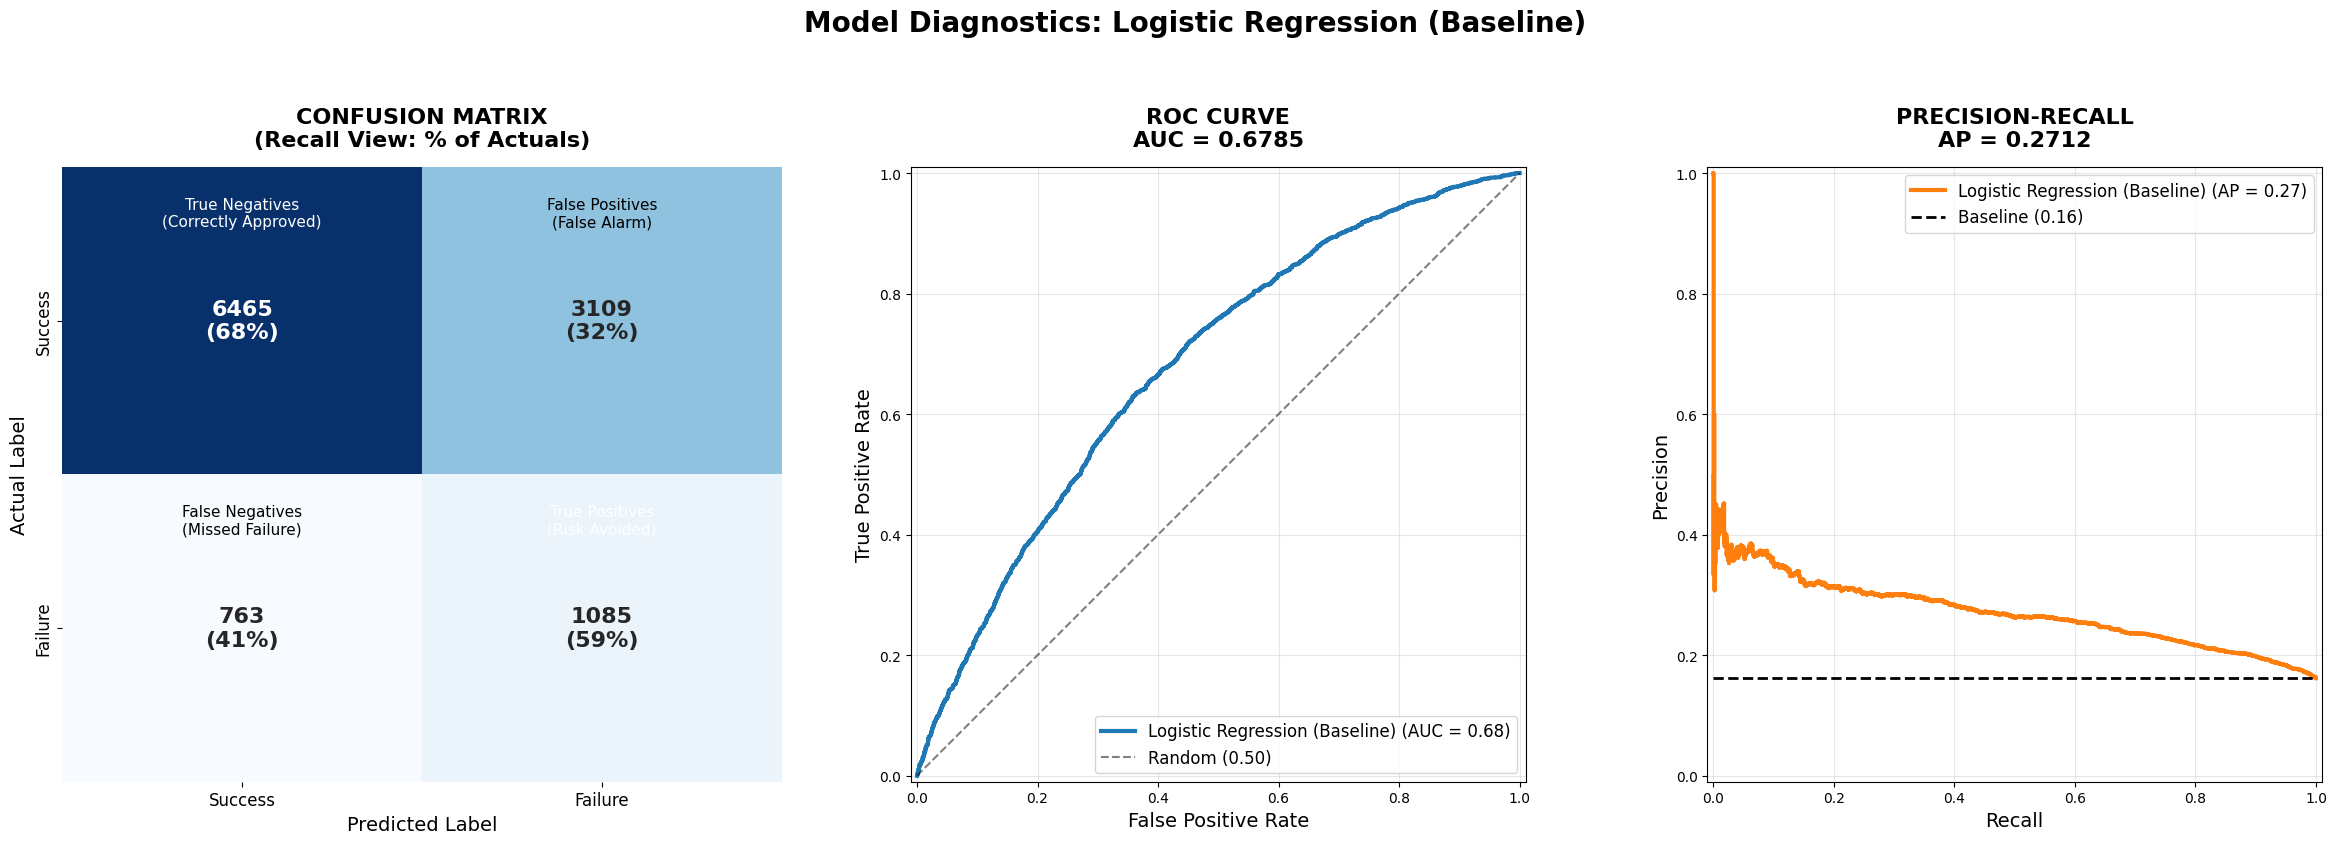

In [ ]:
from src.models.evaluate import evaluate_model
# --- 2. RUN STANDARD EVALUATION ---
# This generates the Scorecard, Confusion Matrix, ROC, and PR Curves
print(">>> Running Standard Evaluation...")
metrics = evaluate_model(model, X_test, y_test, model_name="Logistic Regression (Baseline)")

Recovered Test Data with Metadata: (11422, 148)

 💼 BUSINESS INTELLIGENCE & VINTAGE ANALYSIS

[1] PERFORMANCE BY SEGMENT
   Dimension       Segment  Count Fail_Rate ROC_AUC PR_AUC
SPONSOR_TIER  TIER_2_OTHER   9784     16.1%   0.685  0.276
SPONSOR_TIER  TIER_1_GIANT   1638     16.8%   0.646  0.243
       PHASE PHASE2/PHASE3    522     12.1%   0.714  0.241
       PHASE        PHASE3   2994     13.7%   0.661  0.230
       PHASE PHASE1/PHASE2   1259     24.7%   0.642  0.357
       PHASE        PHASE2   4760     19.2%   0.642  0.284
AGENCY_CLASS       NETWORK     79     16.5%   0.786  0.429
AGENCY_CLASS         OTHER   5997     15.5%   0.704  0.283
AGENCY_CLASS     OTHER_GOV    155      7.7%   0.695  0.206
AGENCY_CLASS           NIH    156     13.5%   0.693  0.323
AGENCY_CLASS           FED     53     22.6%   0.675  0.491
AGENCY_CLASS      INDUSTRY   4962     17.3%   0.657  0.268

[2] VINTAGE ANALYSIS (Stability Check)


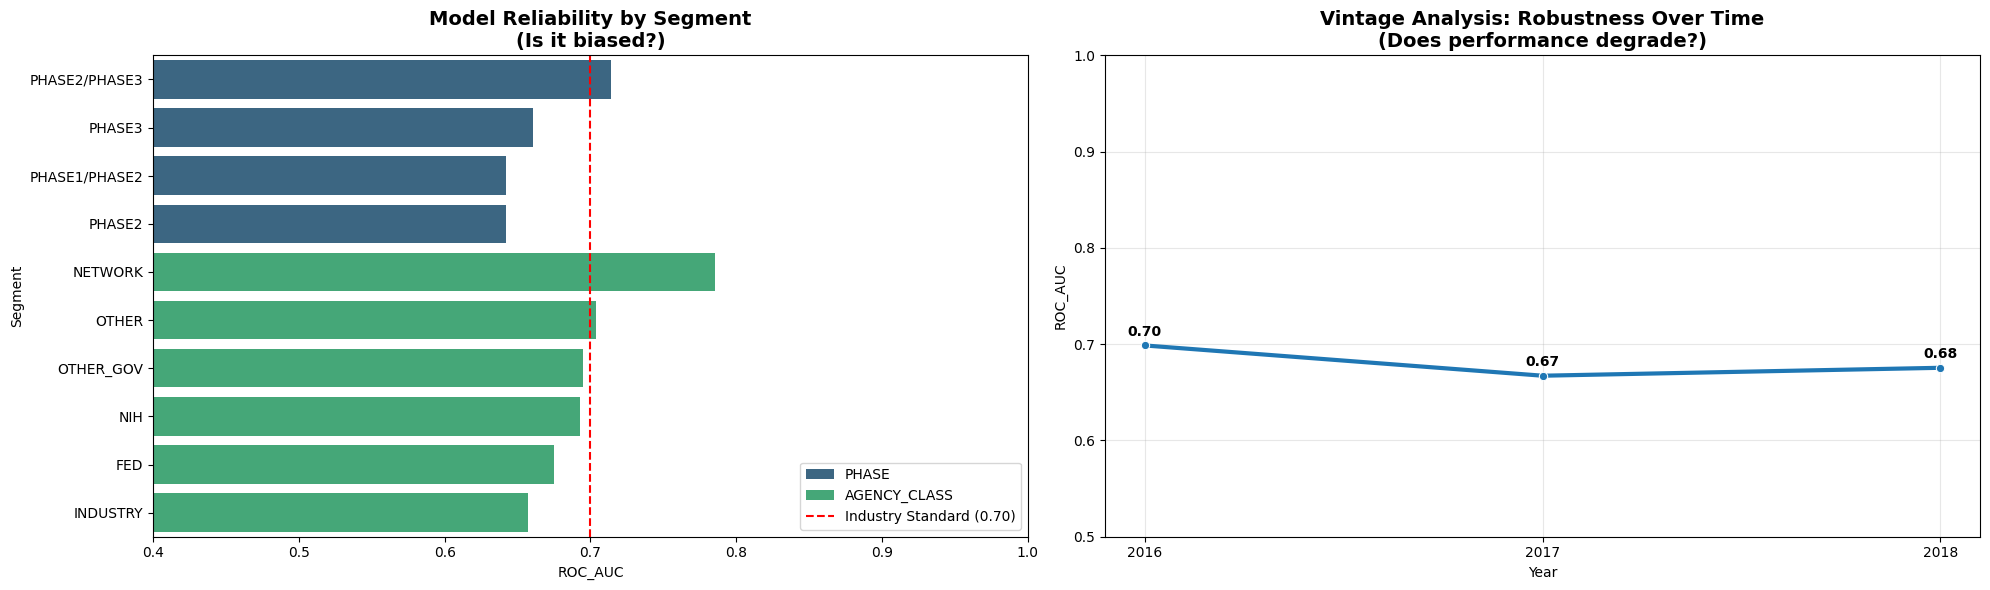

In [52]:
from src.models.evaluate import evaluate_business_slices

# 1. Manually recreate the Test Split to keep ALL columns (Metadata)
# We use the exact same logic: Sort by Date -> Take the last 20%
df_sorted = df.sort_values('start_date').reset_index(drop=True)
split_index = int(len(df_sorted) * 0.80)

# This df_test_full contains 'phase', 'agency_class', etc.
df_test_full = df_sorted.iloc[split_index:].copy()

print(f"Recovered Test Data with Metadata: {df_test_full.shape}")

# 2. Run the Business Analysis
# Note: We pass 'model_lr' (or 'model') and the full dataframe
evaluate_business_slices(model, df_test_full)

### How to Read the Graphs (Cheat Sheet)

**1. Confusion Matrix (Operational Impact)**
*   **Bottom Left (False Negatives):** The "Capital Loss" quadrant. The model said "Safe", but the trial failed. Investors lose money here.
*   **Top Right (False Positives):** The "Opportunity Cost" quadrant. The model said "Risky", but the trial succeeded. Pharma misses a good drug here.

**2. ROC Curve (Global Separability)**
*   **What it tells us:** How good is the model generally?
*   **The Line:** The more it hugs the top-left corner, the better.
*   **The Diagonal:** If the line is on the diagonal, the model is guessing (useless).

**3. Precision-Recall Curve (The Imbalance Truth)**
*   **What it tells us:** Can we trust the "Risk" flags?
*   **Context:** Since failures are rare (15%), this is the most honest view.
*   **The Baseline:** The dashed line represents the failure rate (0.15). We want our curve to be significantly higher than this line.

**4. Temporal Learning Curve (Stability)**
*   **Blue Line:** How well the model knows history.
*   **Orange Line:** How well the model predicts the future.
*   **Convergence:** We want the Orange line to go UP and get closer to the Blue line as we add more data. If the Orange line stays flat, adding more data won't help (we need better features).

### Save model (not to have to re-run model.fit next time so that you start with the correct weights)
prerequisite will be Train_test_split to recuperate the X_train, y_train, X_test, y_test to feed into pretrained model.

In [ ]:
# --- 5. Save the Model ---
from src.models.model_utils import save_model
# Save the Logistic Regression model
# This will create 'src/models/logreg_model.joblib'
save_model(model, 'logreg_baseline.joblib')

print("✅ Model successfully saved to disk.")

>>> Saving model to: /home/delaunan/code/delaunan/clintrialpredict/src/models/logreg_model.joblib
✅ Model successfully saved to disk.


### Imprort pre-trained model (not to have to re-run model.fit)
prerequisite Train_test_split to recuperate the X_train, y_train, X_test, y_test to feed into pretrained model.

In [ ]:
# Import the loader
from src.models.model_utils import load_model

# Retrieve the model from the file
my_loaded_model = load_model('logreg_baseline.joblib')

# Verify it works by making a prediction on the first 5 rows of test data
print("\nTesting loaded model...")
sample_probs = my_loaded_model.predict_proba(X_test.head(5))[:, 1]
print(f"Predictions for first 5 trials: {sample_probs}")

>>> Loading model from: /home/delaunan/code/delaunan/clintrialpredict/src/models/logreg_model.joblib

Testing loaded model...
Predictions for first 5 trials: [0.40835685 0.31814536 0.59581191 0.11837591 0.33292536]
